## GridWorld
---

Introduction of few basic concepts of classical RL applied to the resolution of the GridWorld problem using state-value function (a function that tells us how good is to be in a certain state based on future rewards that can be achived from there)
<br><br>
We'll use three different approaches:
- Dynamic programming
- Monte Carlo simulation
- Temporal-Difference


---
### The Basics

The objective in RL is to develop agents that can interact with their environment to maximize a specific goal. The basic idea is simple: the agent is aware of its own state, takes an action wich leads him to a new state an receives a reward. Takes a new action and so on:

S(t) → A(t) → R(t) → S(t+1) → A(t+1) → R(t+1) → S(t+2)... 
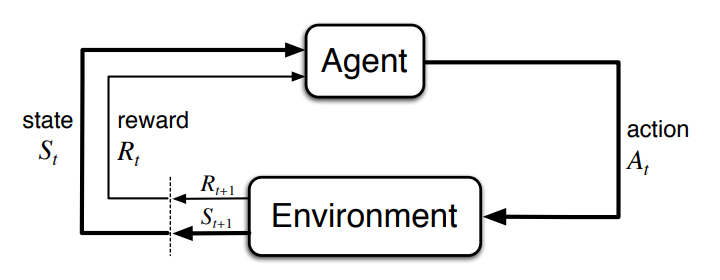

---
### The gridworld task

The agent will have to move in a grid to end up in a termination state (grey squares). Each grid square is a state. The possible actions that can be taken in each state are go up, down, left and right. We assume that these actions are deterministic. If the agent "decides" to go to the left, he goes to the left (in a stochastic environment there will be some probability to end up in a different state than the desired). If the agent hits the wall, it remains in the same state. 
<br><br>
For every movement, the agent receives a reward of -1 except if the initial state is a terminal state, in wich case the reward will be 0 and the episode will end.
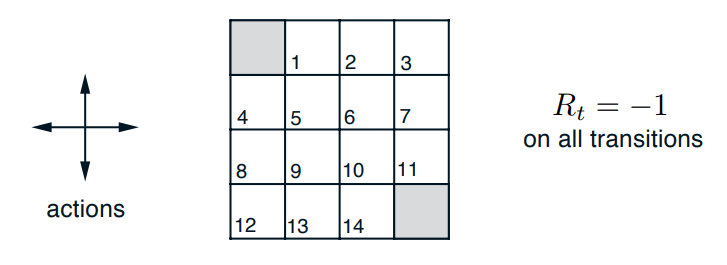

---
### Picking actions

There are different ways the robot could pick an action. The rules based on which the agent picks an action is called the _policy_. One of the simplest policies would be pick a random action among possible actions in the current state. More elaborated policies would consider how good (value) is for the agent to be in (or move to) a grid cell (state)

---
#### 1. Dynamic programming and policy iteration: evaluation and improvement

If the objective is to end up in a grey square, it is evident that is better for the agent to be in a square next to those grey cells because there's higher chance to end up in a terminal state (even with a random policy). But how can we quantify how good are each of those squares/states? Basically, we need a function (known as _state-value_ function) that give us that value (goodness) for each state
<br><br>
But first, we need to "define" the concept of _value_. The value of a state is the sum of all future rewards that can be achived from that state
<br><br>
One way to calculate this state-value function is to use _policy iteration_ 
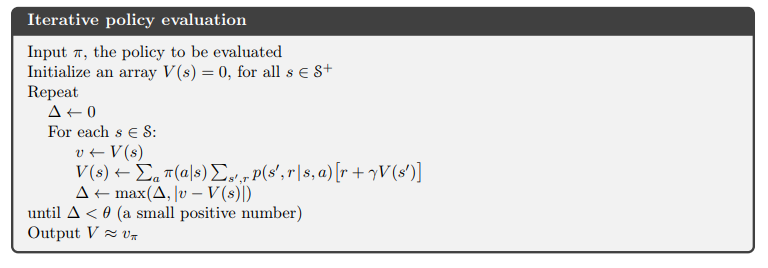

The key to algorithm is the assignment to V(s):
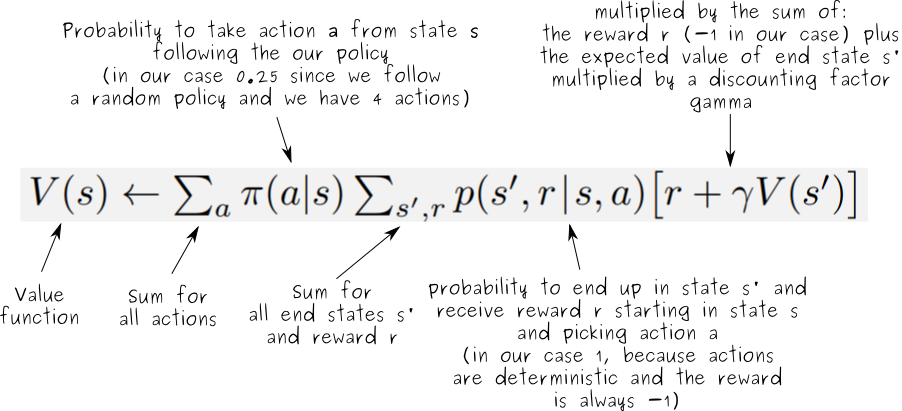

We start with a state's vector initialized with zeroes. We iterate over the states and calculate its new value as a weighted sum of rewards (-1) plus the value of the next states (s'). We repeat the process until reach convergence (the difference between state value and previous value should tend to 0)
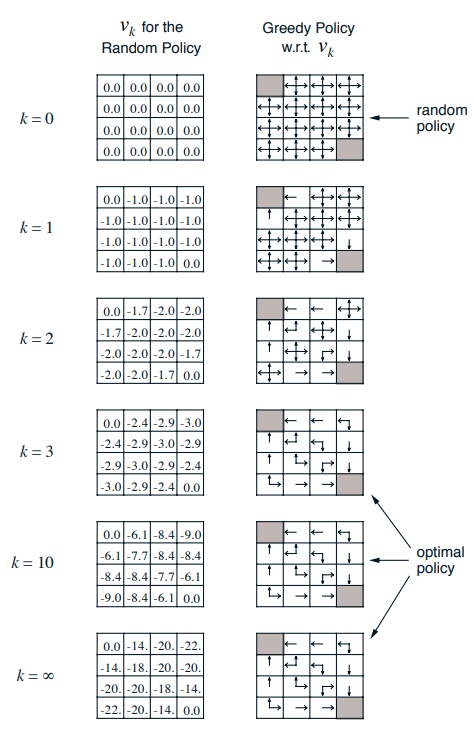

We can see in the right column how, as we update state values, we can generate more efficient policies until we reach the "optimal" one

---
##### Implementation:

Num. iterations: 166

V[s]:
0.00	-13.00	-19.00	-21.00	
-13.00	-17.00	-19.00	-19.00	
-19.00	-19.00	-17.00	-13.00	
-21.00	-19.00	-13.00	0.00	


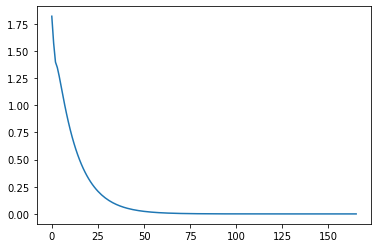

In [1]:
import gym
import gym_gridworld
import numpy as np
import matplotlib.pyplot as plt

def update_V(V, s, e, gamma):
    """Updates state-values using the environment transition matrix e.P
    """
    V_s = 0.
    p_a = .25
    
    for a in range(e.nA):
        (p, ns, r, _) = e.P[s][a][0]
        V_s += p_a*(r + gamma*V[ns])
        
    V[s] = V_s
    
def compute_V_DP_eps(e, gamma, epsilon):
    """Computes states values using dynamic programming approach
    
       The process end when the epsilon condition for deltas is satisfied
    """
    V = np.zeros(e.nS)
    delta_list = []
    
    while(True):
        delta = 0
        for s in range(e.nS):
            v = V[s]
            update_V(V, s, e, gamma)
            delta = max(delta, abs(v - V[s]))

        delta_list.append(delta)

        if delta<epsilon:
            break
            
    return V, delta_list
    
EPSILON = 1E-6
GAMMA = 1

e = gym.make("gridworld-v0")
V, delta_list = compute_V_DP_eps(e, GAMMA, EPSILON)

print("Num. iterations:", len(delta_list))

# print state-values
print("\nV[s]:")
for r in range(4):
    for c in range(4):
        print(f"{V[r*4 + c]:.2f}\t", end="")
        if ((c+1)%4 == 0):
            print()

# plot learning curve     
plt.plot(delta_list)

---
##### Implementation (alt):
Setting max. iterations instead of min. delta (epsilon) as limit

Num. iterations: 1000

V[s]:
0.00	-13.00	-19.00	-21.00	
-13.00	-17.00	-19.00	-19.00	
-19.00	-19.00	-17.00	-13.00	
-21.00	-19.00	-13.00	0.00	


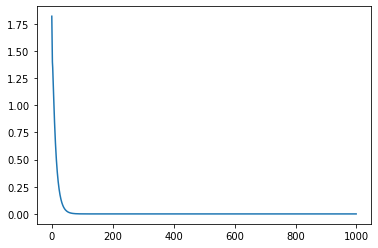

In [2]:
import gym
import gym_gridworld
import numpy as np
import matplotlib.pyplot as plt

def update_V(V, s, e, gamma):
    """Updates state-values using the environment transition matrix e.P
    """
    V_s = 0.
    p_a = .25
    
    for a in range(e.nA):
        (p, ns, r, _) = e.P[s][a][0]
        V_s += p_a*(r + gamma*V[ns])
        
    V[s] = V_s
    
def compute_V_DP_it(e, gamma, iterations):
    """Computes states values using dynamic programming approach
    """
    V = np.zeros(e.nS)
    delta_list = []
    
    for _ in range(iterations):
        delta = 0
        for s in range(e.nS):
            v = V[s]
            update_V(V, s, e, gamma)
            delta = max(delta, abs(v - V[s]))

        delta_list.append(delta)
            
    return V, delta_list    

ITERATIONS = 1000
GAMMA = 1

e = gym.make("gridworld-v0")
V, delta_list = compute_V_DP_it(e, GAMMA, ITERATIONS)

print("Num. iterations:", len(delta_list))

# print state-values
print("\nV[s]:")
for r in range(4):
    for c in range(4):
        print(f"{V[r*4 + c]:.2f}\t", end="")
        if ((c+1)%4 == 0):
            print()

# plot learning curve     
plt.plot(delta_list)

---
#### 2. Monte Carlo methods

In the previous approach we have a complete knowledge of the environment. Monte Carlo methods are able to learn directly from _experience_ or _episodes_ rather than relaying on the prior knowledge of the environment dynamics.
<br><br>
_The term "Monte Carlo" is often used for any estimation method whose operation involves a significant random component_
<br><br>
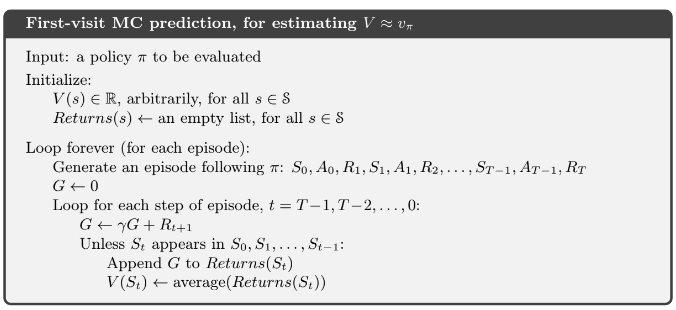

The Monte Carlo approach to solve gridworld is pretty simple. Basically, we produce _n_ simulations (episodes) starting from random cells of the grid and let the agent move randomly until a termination state is achieved. For each step of the episode we save 4 values: initial state, action, reward and final state.
<br><br>
From these episodes, we iterate from the end of the "experience" array and compute G as the previous state value in the same episode (weighed by gamma) plus the reward in that state. If is the first occurrence of the state in the episode (**first visit MC**), we store G in an array of Returns(St) (one for every episode in which the state appears) and compute its average as the state value at a particular iteration.

---
##### Implementation:

Here we define some utility functions (generate random episodes and print the state values) that we'll use through the rest of implementations

In [2]:
"""UTILITY FUNCTIONS
"""
import time
current_milli_time = lambda: int(round(time.time() * 1000))

def gen_episode(e):
    """Generate episodes using a random policy.
    """
    episode = []
    s_ini = e.reset()    
    done = False    
    while not done:
        a = e.action_space.sample()
        s_next, r, done, _ = e.step(a)
        episode.append((s_ini, a, r, s_next))
        s_ini = s_next    
    return episode

def print_V(V, nrows, ncols):
    """Print state-values
    """
    print("\nV[s]:")
    for r in range(nrows):
        for c in range(ncols):
            print(f"{V[r*ncols + c]:.2f}\t", end="")
            if ((c+1)%ncols == 0):
                print()

---

Iterations: 1500
Gamma: 0.9
Time (s): 6.62

V[s]:
0.00	-4.78	-6.90	-7.37	
-4.62	-6.14	-6.86	-6.77	
-6.65	-6.70	-6.10	-4.73	
-7.18	-6.68	-4.69	0.00	


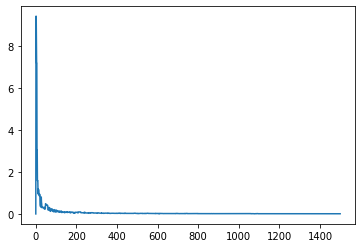

In [4]:
import numpy as np
import gym
import gym_gridworld
import matplotlib.pyplot as plt

def compute_V_MC(e, gamma, iterations, V_ini=None):
    """Compute state values using Monte Carlo.
    """
    if V_ini is None: V = np.zeros(e.nS)
    else: V = np.array(V_ini)
    R = {s:[] for s in range(e.nS)}
    delta = np.zeros(e.nS)
    delta_list = []
    
    for _ in range(iterations):
        episode = gen_episode(e)
        G = 0.
        for i, (s_ini,a,r,s_end) in enumerate(episode[::-1]):
            G = gamma*G + r
            if s_ini not in [eps[0] for eps in episode[:len(episode)-i-1]]:
                R[s_ini].append(G)
                V_new = np.average(R[s_ini])
                delta[s_ini] = np.abs(V[s_ini] - V_new)
                V[s_ini] = V_new
        delta_list.append(np.max(delta))
        
    return V, delta_list
    
ITERATIONS = 1500
GAMMA = .9

e = gym.make("gridworld-v0")
t_ini = current_milli_time()
V, delta_list = compute_V_MC(e, GAMMA, ITERATIONS)
t_end = current_milli_time()

print("Iterations:", ITERATIONS)
print("Gamma:", GAMMA)
print("Time (s):", (t_end-t_ini)/100.0)

print_V(V, 4, 4)

# plot learning curve     
plt.plot(delta_list)

---
##### Implementation (alt):
Even though it is not a continuous problem, the **incremental mean update** should reduce computing time and memory use. 

Iterations: 1000
Gamma: 0.9
Time (s): 2.25

V[s]:
0.00	-4.53	-6.81	-7.47	
-4.66	-6.11	-6.81	-6.83	
-6.95	-6.94	-6.39	-5.08	
-7.39	-6.89	-5.06	0.00	


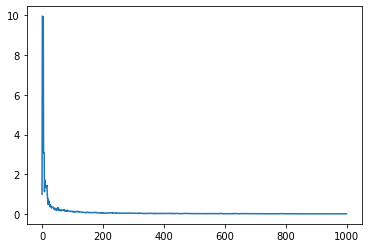

In [3]:
import numpy as np
import gym
import gym_gridworld
import matplotlib.pyplot as plt

def compute_V_MC_inc(e, gamma, iterations, V_ini=None):
    """Compute state values using Monte Carlo with incremental mean update
    """
    if V_ini is None: V = np.zeros(e.nS)
    else: V = np.array(V_ini)
    N = np.zeros(e.nS)
    delta = np.zeros(e.nS)
    delta_list = []
    
    for _ in range(iterations):
        episode = gen_episode(e)
        G = 0.
        for i, (s_ini,a,r,s_end) in enumerate(episode[::-1]):
            G = gamma*G + r
            if s_ini not in [eps[0] for eps in episode[:len(episode)-i-1]]:
                N[s_ini] += 1
                V_old = V[s_ini]
                V[s_ini] += (1/N[s_ini])*(G - V_old)
                delta[s_ini] = np.abs(V_old - V[s_ini])
        delta_list.append(np.max(delta))
        
    return V, delta_list

ITERATIONS = 1000
GAMMA = .9

e = gym.make("gridworld-v0")
t_ini = current_milli_time()
V, delta_list = compute_V_MC_inc(e, GAMMA, ITERATIONS)
t_end = current_milli_time()

print("Iterations:", ITERATIONS)
print("Gamma:", GAMMA)
print("Time (s):", (t_end-t_ini)/100.0)

print_V(V, 4, 4)

# plot learning curve     
plt.plot(delta_list)

---
#### 3. Temporal-Difference learning

Finally, the last method we will explore is temporal-difference (TD). This third method is said to merge the best of dynamic programming and the best of MC approaches:
<br>
1. As the dynamic programming method, during the optimization of the value function for an initial state, we use the expected values of next state to enrich the prediction. This process is called bootstrapping.
<br><br>
2. As in MC, we don't have a model of the environment dynamics and can learn directly from experience
<br><br>
3. Unlike MC, we don't have to wait until the end of the episode to start learning. This is very useful in continuous episodes (absence of terminal state) and non-deterministic non-episodic or time-varying value functions
<br><br>
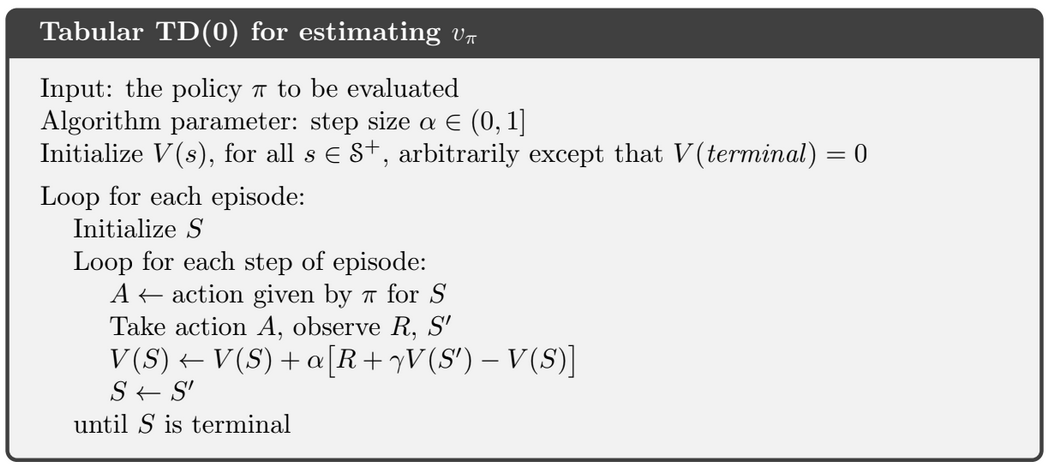


---
##### Implementation:

Iterations: 1000
Gamma: 0.95
Alpha: 0.1
Time (s): 2.46

V[s]:
0.00	-5.70	-10.39	-11.43	
-7.60	-9.20	-10.44	-10.24	
-9.84	-10.35	-8.96	-7.32	
-11.42	-10.74	-7.77	0.00	


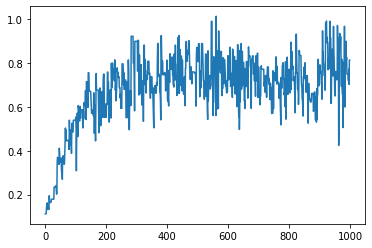

In [4]:
import numpy as np
import gym
import gym_gridworld
import matplotlib.pyplot as plt

def compute_V_TD(e, alpha, gamma, iterations, V_ini=None):
    """Compute state values using Monte Carlo with incremental mean update
    """
    if V_ini is None: V = np.zeros(e.nS)
    else: V = np.array(V_ini)
    delta = np.zeros(e.nS)
    delta_list = []

    for _ in range(iterations):
        episode = gen_episode(e)
        for i, (s_ini,a,r,s_end) in enumerate(episode):
            V_old = V[s_ini]
            V[s_ini] = (1 - alpha)*V[s_ini] + alpha*(r + gamma*V[s_end])
            delta[s_ini] = np.abs(V_old - V[s_ini])
        delta_list.append(np.max(delta))
        
    return V, delta_list
    
ITERATIONS = 1000
GAMMA = .95
ALPHA = .1

e = gym.make("gridworld-v0")
t_ini = current_milli_time()
V, delta_list = compute_V_TD(e, ALPHA, GAMMA, ITERATIONS)
t_end = current_milli_time()

print("Iterations:", ITERATIONS)
print("Gamma:", GAMMA)
print("Alpha:", ALPHA)
print("Time (s):", (t_end-t_ini)/100.0)

print_V(V, 4, 4)

# plot learning curve     
plt.plot(delta_list)

---
### Exploiting the learned state values

Once we learned the optimal state values, we can define a greedy policy to "force" the agent to take actions that moves him to the next best state in order to reach the goal. The next implementation will define the aforementioned policy. 
<br><br>
In order to display the learning process, instead of calculate the optimal values through all iterations first and, later, apply those learned values to the agent, we'll do it per iteration. That is to say, we'll compute the state values for one iteration and we'll test how the agent performs in finding the goal with those values. Then, we'll compute new values for the states from the previous ones and the agent will explore again. And so on until the final iteration. This way, we can render the learning process of the agent.

In [10]:
import gym
from gym import wrappers
import gym_gridworld
import numpy as np
import time
from IPython.display import clear_output

ITERATIONS = 10
GAMMA = .9
SLEEP = .5
MAX_STEPS = 50

def test_agent(e, V, i):
    def select_action(s):
        # get (action, next_state value) for every action from current state
        # we add some random value to avoid taking always the first action when there are
        # repeated state values
        a_ns_value = [(a, V[n[0][1]] + np.random.random()/1E3) for a,n in e.P[s].items() if n[0][1]!=s]
        # get the action with greater next state value (greedy)
        print(a_ns_value)
        a = a_ns_value[np.argmax(a_ns_value, axis=0)[1]][0]        
        return a

    def render():
        #print("\033[2J\033[H")  # clear + home
        clear_output(wait=True)
        print("EPISODE:", i)
        print("==================")
        e.render()

    s = e.reset()
    done = False
    while not done:
        render()
        print_V(V, 4, 4)
        a = select_action(s)
        s, r, done, _ = e.step(a)
        print("next action:", a)
        time.sleep(SLEEP)
    render()
    print_V(V, 4, 4)
    time.sleep(SLEEP)

e = gym.make("gridworld-v0")
e.max_episode_steps = MAX_STEPS
e = gym.wrappers.Monitor(e, "video_rec", video_callable=lambda episode_id: True, force=True)

V = np.zeros(e.nS)
for i in range(ITERATIONS):
    # render agent episode for current state values
    test_agent(e, V, i+1)
    
    # iterate from the previous state values
    V, delta_list = compute_V_MC_inc(e, GAMMA, ITERATIONS, V)

e.close()

EPISODE: 10
X╎ ╎ ╎ 
╌ ╌ ╌ ╌
 ╎ ╎ ╎ 
╌ ╌ ╌ ╌
 ╎ ╎ ╎ 
╌ ╌ ╌ ╌
 ╎ ╎ ╎O

V[s]:
0.00	-6.66	-5.29	-6.73	
-3.92	-4.90	-4.82	-3.01	
-8.32	-6.80	-3.71	-1.64	
-8.12	-7.32	-2.39	0.00	
